# **Captcha Recognition**

## **Objective**

Develop an AI-based system that can accurately recognize and extract numerical strings from
CAPTCHA images.

## **Problem** **Statement**

In this challenge, you will be provided with a dataset of CAPTCHA images, each containing a
numerical string. Your task is to build a system that can process these images and output the
corresponding numerical string with high accuracy. CAPTCHA images often include distortions,
noise, and varying fonts to prevent automated recognition, so your solution should demonstrate
robustness against such challenges.

## Importing Required Libraries

Imports essential libraries like NumPy, PyTorch, OpenCV, and Albumentations.
These are used for dataset handling, deep learning model training, and image processing.

In [2]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import glob
import cv2
import csv
import tqdm
import albumentations as A
import matplotlib.pyplot as plt

## Mounting Google Drive

Connects to Google Drive to access the dataset and save model checkpoints.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Config Values
Defining Paths and Hyperparameters
Specifies paths for training/validation datasets and ground truth labels.
Sets batch size, learning rate, image dimensions, and device configuration.

In [3]:
train_path = "/content/drive/MyDrive/dataset/train-images/train-images/"
val_path = "/content/drive/MyDrive/dataset/validation-images/validation-images/"
gt_csv_path = "/content/drive/MyDrive/dataset/captcha_data.csv"

ckpt_path = "/content/drive/MyDrive/dataset/models/"

batch_size = 16
num_workers = 2
learning_rate = 5e-4
num_epochs = 10000

img_width = 256
img_height = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

### Transformations using Albumentations

Defines image augmentation techniques such as resizing, normalization, and flipping.

In [4]:
train_transforms = A.Compose([
        A.Compose([  # Rescale transform
            A.RandomScale(scale_limit=(-0.3, -0.1), always_apply=True),
            A.PadIfNeeded(min_height=64, min_width=30,
                          border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), always_apply=True),
            A.Rotate(limit=4, p=0.5, crop_border=True),
        ], p=0.4),
        A.GaussianBlur(blur_limit = (0, 1), p=0.5),
        A.OneOf([  # Geometric transforms
            A.GridDistortion(always_apply=True, num_steps=7, distort_limit=0.5,
                             border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), normalized=True),
            A.OpticalDistortion(always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
            A.Perspective(scale=0.1, always_apply=True, fit_output=True, pad_val=(255, 255, 255))
        ], p=0.5),
        A.ISONoise(p=0.1),
        A.ImageCompression(quality_lower=30, p=0.2),
        A.GaussNoise(std_range=(0.1, 0.2), p=0.1),
    ])

<ipython-input-4-be286e06538f>:3: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomScale
  A.RandomScale(scale_limit=(-0.3, -0.1), always_apply=True),
<ipython-input-4-be286e06538f>:4: UserWarning: Argument(s) 'value, always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=64, min_width=30,
<ipython-input-4-be286e06538f>:10: UserWarning: Argument(s) 'always_apply, border_mode, value' are not valid for transform GridDistortion
  A.GridDistortion(always_apply=True, num_steps=7, distort_limit=0.5,
<ipython-input-4-be286e06538f>:12: UserWarning: Argument(s) 'always_apply, border_mode, value' are not valid for transform OpticalDistortion
  A.OpticalDistortion(always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
<ipython-input-4-be286e06538f>:13: UserWarning: Argument(s) 'always_apply, pad_val' are not valid for transform Perspective
  A.Perspective(scale=0.1, always_apply=True, fit_output=True, pad_val=(255, 255, 255))

### Custom Dataset Class

Defining a Custom Dataset Class

Implements a PyTorch Dataset class to load images and corresponding labels.
Applies image augmentations for better generalization.

In [68]:
class CaptchaDataset(Dataset):
  CHARS = '0123456789'
  CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
  LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}
  def __init__(self, is_train = True):
    self.images_gt_dict = {}
    with open(gt_csv_path, 'r') as file:
      lines = csv.DictReader(file)
      for line in lines:
        self.images_gt_dict[line["image_path"].strip()] = line["solution"].strip() #image_path -> numerical string(Ground Truth)
    if is_train == True:
      self.images_list = glob.glob(train_path + "*")
    else:
      self.images_list = glob.glob(val_path + "*")

  def preprocess(self, img):

    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = train_transforms(image=img)['image']
    img = cv2.resize(img, (img_width, img_height),
               interpolation = cv2.INTER_LINEAR)
    img = img / 255.0
    img = torch.FloatTensor(img)
    img = torch.permute(img, (2, 0, 1))
    return img

  def __getitem__(self, index):
    img_path = self.images_list[index]
    img = cv2.imread(img_path)
    img = self.preprocess(img)

    # if img is None:
    #   return self.__getitem__(self, index+1)
    gt = self.images_gt_dict[img_path.split('/')[-2] + '/' + img_path.split('/')[-1]]
    sample = {}
    target = [self.CHAR2LABEL[c] for c in gt]
    target_length = [len(target)]

    target = torch.LongTensor(target)
    target_length = torch.LongTensor(target_length)
    return img, target, target_length

  def __len__(self):
    return len(self.images_list)

def captcha_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

### Loading and Preprocessing Data

Uses DataLoader to create batches for efficient training.

In [69]:
train_dataset = CaptchaDataset(is_train=True)
val_dataset = CaptchaDataset(is_train=False)
print(len(train_dataset))
print(len(val_dataset))

6000
2000


In [70]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=captcha_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle= False, collate_fn=captcha_collate_fn)

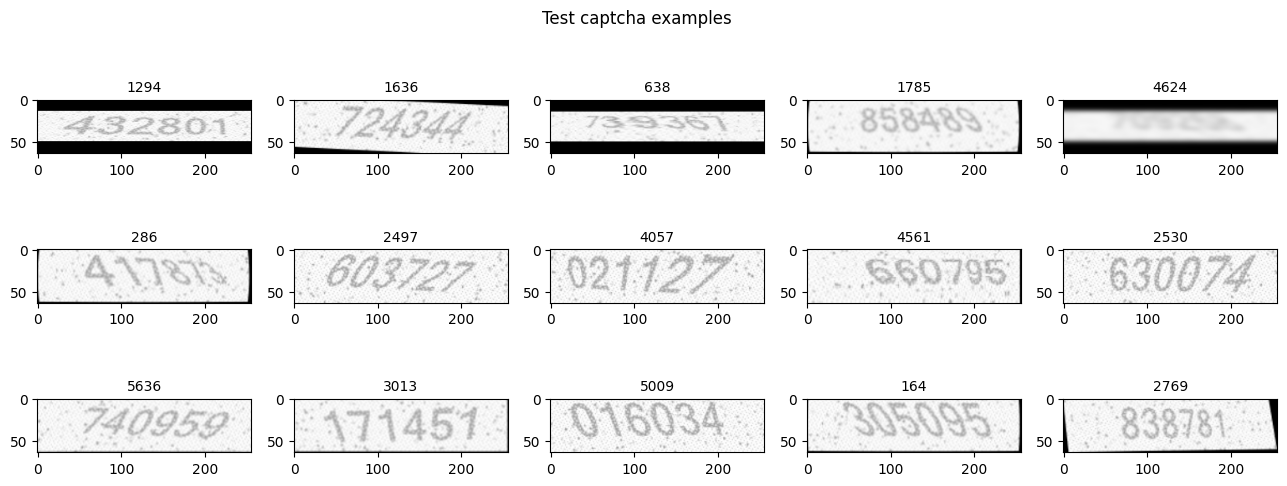

In [72]:
fig, axs = plt.subplots(3, 5, figsize=(16, 5.5))
for i in range(15):
    ax = axs[i // 5][i % 5]
    random_index = np.random.randint(0, len(train_dataset))
    image, target, target_lengths = train_dataset.__getitem__(random_index)

    image = torch.permute(image, (1, 2, 0))
    img = image.numpy()
    ax.imshow(img)
    ax.grid(False)
    ax.set_title(f'{random_index}', fontsize=10)
fig.suptitle('Test captcha examples')
plt.show()

## Defining the CAPTCHA Recognition Model

Implements a Convolutional Recurrent Neural Network (CRNN) with fully connected layers.
Uses a CTC (Connectionist Temporal Classification) loss for sequence-based recognition.

### Architecture 1

In [73]:
class ConvBlock(nn.Module):

    def __init__(self, in_ch, out_ch, ks, stride, padding, dilation=1, pool_ks=None):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_ch)
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ks,
                              stride=stride, padding=padding, dilation=dilation, bias=False)
        self.pooling = nn.MaxPool2d(kernel_size=pool_ks) if pool_ks is not None else None
        self.activation = nn.Hardswish()

    def forward(self, x):
        x = self.conv(self.bn(x))
        if self.pooling:
            x = self.pooling(x)
        x = self.activation(x)
        return x

class CNNImageEncoder(nn.Module):

    """
    This model accept images with size (64x256).
    It reduces the size of H component to 1, so we can use W component as sequence for RNN.
    """

    def __init__(self, out_dim=128, dropout=0.1):
        super().__init__()
        # self.pre_bath_norm = nn.BatchNorm2d(3)
        self.layers = nn.Sequential(
            ConvBlock(3, 32, 9, 1, 4, pool_ks=2),
            ConvBlock(32, 64, 7, 1, 3, pool_ks=2),
            ConvBlock(64, 128, 5, 1, 2, pool_ks=(2, 1)),
            ConvBlock(128, 128, 3, 1, 1, pool_ks=(2, 1)),
            ConvBlock(128, 128, 3, 1, 1, pool_ks=(2, 1)),
            ConvBlock(128, 128, 3, 1, 1, pool_ks=(2, 1)),
        )  # [b, 128, 1, 64]
        self.dropout = nn.Dropout(dropout)
        self.out_net = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        # x = self.pre_bath_norm(x)  # [b, 3, h, w]
        x = self.layers(x)  # [b, ch, 2, w]
        x = x.permute(0, 3, 1, 2)  # [b, w, ch, 2]
        x = x.flatten(-2)  # [b, w, 2*ch]
        x = self.dropout(x)
        x = self.out_net(x)  # [b, 64, out_dim]
        return x

class BiLSTMImageDecoder(nn.Module):

    def __init__(self, in_dim, hidden_dim, vocab_size, lstm_layers, dropout=0.1):
        super().__init__()
        self.norm = nn.BatchNorm1d(64)
        self.rnn = nn.LSTM(in_dim, hidden_dim, num_layers=lstm_layers, dropout=dropout, bidirectional=True,
                           batch_first=False)
        self.out_proj = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x = self.norm(x)
        x = x.permute(1, 0, 2)  # [B, T, in_dim] to [T, B, in_dim]
        rnn_out, _ = self.rnn(x)
        x = self.out_proj(rnn_out)
        return x


class OCR_CRNN(nn.Module):

    def __init__(self, vocab_size, hidden_dim=128, lstm_layers=2, dropout=0.1):
        super().__init__()
        self.encoder = CNNImageEncoder(out_dim=hidden_dim, dropout=dropout)
        self.decoder = BiLSTMImageDecoder(in_dim=hidden_dim, hidden_dim=hidden_dim,
                                          vocab_size=vocab_size, lstm_layers=lstm_layers, dropout=dropout)
        self.softmax = nn.LogSoftmax(-1)  # for CTCLoss

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.softmax(x)
        return x


### Architecture 2

In [74]:
class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = \
            channels[-1], img_height // 16 - 1, img_width // 4 - 1
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()
        print(conv.shape)
        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        print(conv.shape)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

## Initializing the Model and Loss Function

Moves the model to the appropriate device (CPU/GPU).
Defines the loss function and optimizer.

In [75]:
num_classes = len(CaptchaDataset.LABEL2CHAR)+1
print(num_classes)
model = CRNN(1, img_height=img_height, img_width=img_width, num_class=num_classes).to(device)
model2 = OCR_CRNN(vocab_size=num_classes).to(device)
criterion = nn.CTCLoss(reduction='sum', zero_infinity=True).to(device)
optimizer = torch.optim.AdamW(model2.parameters(), lr = learning_rate)

11


In [76]:
x = torch.randn((1, 3, 64, 256)).to(device)
y = model2(x)
print(y.shape)

torch.Size([64, 1, 11])


## Decoding the Model Predictions
Converts raw model outputs into readable CAPTCHA text.

In [77]:
def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]

    return new_labels


def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels

def ctc_decode(log_probs, label2char=None, blank=0):
    emission_log_probs = np.transpose(log_probs.detach().cpu().numpy(), (1, 0, 2))
    # size of emission_log_probs: (batch, length, class)

    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = greedy_decode(emission_log_prob, blank=blank)
        if label2char:
            decoded = [label2char[l] for l in decoded]
        decoded_list.append(decoded)
    return decoded_list

In [78]:
def evaluate_model():
  tot_count = 0
  tot_loss = 0.0
  tot_correct = 0
  for i, sample in tqdm.tqdm(enumerate(val_loader)):
    with torch.no_grad():
      images, targets, target_lengths = [d.to(device) for d in sample]
      logits = model2(images)
      log_probs = nn.functional.log_softmax(logits, dim=2)
      # print(log_probs)
      bs = images.size(0)
      input_lengths = torch.LongTensor([logits.size(0)] * bs)

      loss = criterion(log_probs, targets, input_lengths, target_lengths)

      preds = ctc_decode(log_probs)
      reals = targets.cpu().numpy().tolist()
      # print(target_lengths.shape)
      target_lengths = torch.flatten(target_lengths).cpu().numpy().tolist()
      # print(target_lengths)

      tot_count += bs
      tot_loss += loss.item()
      target_length_counter = 0
      for pred, target_length in zip(preds, target_lengths):
          real = reals[target_length_counter:target_length_counter + target_length]
          target_length_counter += target_length
          # print(pred, real)
          if pred == real:
              tot_correct += 1
  acc = tot_correct/tot_count
  val_loss = tot_loss/ tot_count
  return acc, val_loss


## Training Loop Implementation

Iterates over epochs, processing batches of images.
Computes loss and updates model parameters.
Computes Validation Loss and accuracy at each epoch

In [79]:
loss_values = []
for epoch in range(num_epochs):
  for i, sample in tqdm.tqdm(enumerate(train_loader)):
    images, targets, target_lengths = [d.to(device) for d in sample]
    # print(images.shape)
    logits = model2(images)
    # log_probs = nn.functional.log_softmax(logits, dim=2)

    bs = images.shape[0]
    input_lengths = torch.full(size=(images.shape[0],), fill_value=logits.shape[0], dtype=torch.long)
    # print(input_lengths)
    target_lengths = torch.flatten(target_lengths)
    # print(target_lengths)

    loss = criterion(logits, targets, input_lengths, target_lengths)
    loss_values.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    if((i+1) % 50 == 0):
      print(f"Epoch = {epoch+1}/{num_epochs}, step = {(i+1)} / {(len(train_dataset) / batch_size)}, loss = {loss.item() / batch_size:.8f}")

  if ((epoch+1)%10) == 0:
    acc, val_loss = evaluate_model()
    print(f"Epoch = {epoch+1}/{num_epochs}, Accuracy = {acc}, Val_loss = {val_loss}")
  torch.save(model, ckpt_path + f"model_{epoch}.pth")



51it [00:06,  9.28it/s]

Epoch = 1/10000, step = 50 / 375.0, loss = 15.78499508


101it [00:11,  9.48it/s]

Epoch = 1/10000, step = 100 / 375.0, loss = 15.63869095


151it [00:15,  8.99it/s]

Epoch = 1/10000, step = 150 / 375.0, loss = 15.68941307


202it [00:21, 10.62it/s]

Epoch = 1/10000, step = 200 / 375.0, loss = 15.60963726


252it [00:26, 11.01it/s]

Epoch = 1/10000, step = 250 / 375.0, loss = 15.63965321


302it [00:31,  8.46it/s]

Epoch = 1/10000, step = 300 / 375.0, loss = 15.51919174


352it [00:37, 11.29it/s]

Epoch = 1/10000, step = 350 / 375.0, loss = 15.52579308


375it [00:39,  9.56it/s]
52it [00:05,  8.14it/s]

Epoch = 2/10000, step = 50 / 375.0, loss = 15.59581375


102it [00:10, 10.45it/s]

Epoch = 2/10000, step = 100 / 375.0, loss = 15.55211830


152it [00:15, 10.94it/s]

Epoch = 2/10000, step = 150 / 375.0, loss = 15.56484985


200it [00:20,  7.85it/s]

Epoch = 2/10000, step = 200 / 375.0, loss = 15.77520943


252it [00:26, 10.39it/s]

Epoch = 2/10000, step = 250 / 375.0, loss = 15.49224281


302it [00:31, 10.66it/s]

Epoch = 2/10000, step = 300 / 375.0, loss = 15.56499863


350it [00:36,  6.88it/s]

Epoch = 2/10000, step = 350 / 375.0, loss = 15.53551483


375it [00:39,  9.54it/s]
51it [00:04, 10.45it/s]

Epoch = 3/10000, step = 50 / 375.0, loss = 15.57314014


100it [00:10,  6.56it/s]

Epoch = 3/10000, step = 100 / 375.0, loss = 15.56161308


152it [00:16, 11.08it/s]

Epoch = 3/10000, step = 150 / 375.0, loss = 15.58100891


202it [00:20, 10.91it/s]

Epoch = 3/10000, step = 200 / 375.0, loss = 15.57664394


252it [00:26,  9.18it/s]

Epoch = 3/10000, step = 250 / 375.0, loss = 15.48269272


302it [00:31, 10.49it/s]

Epoch = 3/10000, step = 300 / 375.0, loss = 14.98561954


351it [00:36, 10.37it/s]

Epoch = 3/10000, step = 350 / 375.0, loss = 14.98181152


375it [00:39,  9.58it/s]
51it [00:05,  8.89it/s]

Epoch = 4/10000, step = 50 / 375.0, loss = 14.27771950


100it [00:10,  7.62it/s]

Epoch = 4/10000, step = 100 / 375.0, loss = 12.76850319


152it [00:15, 11.51it/s]

Epoch = 4/10000, step = 150 / 375.0, loss = 12.08409977


203it [00:20, 12.21it/s]

Epoch = 4/10000, step = 200 / 375.0, loss = 10.06863022


250it [00:25,  7.60it/s]

Epoch = 4/10000, step = 250 / 375.0, loss = 8.00596714


302it [00:31, 11.77it/s]

Epoch = 4/10000, step = 300 / 375.0, loss = 6.78793335


350it [00:35,  9.78it/s]

Epoch = 4/10000, step = 350 / 375.0, loss = 2.85524464


375it [00:38,  9.81it/s]
51it [00:05, 10.31it/s]

Epoch = 5/10000, step = 50 / 375.0, loss = 1.79353452


101it [00:10,  9.49it/s]

Epoch = 5/10000, step = 100 / 375.0, loss = 2.47106981


151it [00:16,  7.86it/s]

Epoch = 5/10000, step = 150 / 375.0, loss = 2.88542151


201it [00:20, 11.48it/s]

Epoch = 5/10000, step = 200 / 375.0, loss = 1.94239640


253it [00:25, 11.14it/s]

Epoch = 5/10000, step = 250 / 375.0, loss = 0.52879941


301it [00:31,  7.41it/s]

Epoch = 5/10000, step = 300 / 375.0, loss = 0.64462781


352it [00:35, 10.90it/s]

Epoch = 5/10000, step = 350 / 375.0, loss = 0.75090235


375it [00:38,  9.86it/s]
51it [00:06,  7.12it/s]

Epoch = 6/10000, step = 50 / 375.0, loss = 0.44561309


102it [00:12,  8.66it/s]

Epoch = 6/10000, step = 100 / 375.0, loss = 1.01121080


152it [00:17,  9.07it/s]

Epoch = 6/10000, step = 150 / 375.0, loss = 0.46383440


201it [00:23, 10.96it/s]

Epoch = 6/10000, step = 200 / 375.0, loss = 0.19331314


251it [00:27, 10.81it/s]

Epoch = 6/10000, step = 250 / 375.0, loss = 0.17048299


301it [00:32,  8.87it/s]

Epoch = 6/10000, step = 300 / 375.0, loss = 0.15958872


352it [00:38, 11.34it/s]

Epoch = 6/10000, step = 350 / 375.0, loss = 0.53690284


375it [00:40,  9.34it/s]
51it [00:04,  9.11it/s]

Epoch = 7/10000, step = 50 / 375.0, loss = 0.07391183


102it [00:10, 10.79it/s]

Epoch = 7/10000, step = 100 / 375.0, loss = 0.14801885


152it [00:15, 11.16it/s]

Epoch = 7/10000, step = 150 / 375.0, loss = 0.44508359


201it [00:20,  7.87it/s]

Epoch = 7/10000, step = 200 / 375.0, loss = 0.94577527


252it [00:26, 10.84it/s]

Epoch = 7/10000, step = 250 / 375.0, loss = 0.34250984


302it [00:30, 11.74it/s]

Epoch = 7/10000, step = 300 / 375.0, loss = 0.23167883


350it [00:35,  7.22it/s]

Epoch = 7/10000, step = 350 / 375.0, loss = 1.74482846


375it [00:38,  9.66it/s]
51it [00:04, 10.41it/s]

Epoch = 8/10000, step = 50 / 375.0, loss = 0.45704448


101it [00:09, 10.36it/s]

Epoch = 8/10000, step = 100 / 375.0, loss = 0.43652725


152it [00:15, 10.27it/s]

Epoch = 8/10000, step = 150 / 375.0, loss = 0.08281776


202it [00:20, 11.01it/s]

Epoch = 8/10000, step = 200 / 375.0, loss = 0.35506567


252it [00:25, 11.37it/s]

Epoch = 8/10000, step = 250 / 375.0, loss = 0.08788523


302it [00:30, 10.76it/s]

Epoch = 8/10000, step = 300 / 375.0, loss = 0.20302981


352it [00:35, 11.19it/s]

Epoch = 8/10000, step = 350 / 375.0, loss = 0.94104421


375it [00:37,  9.94it/s]
50it [00:05,  7.26it/s]

Epoch = 9/10000, step = 50 / 375.0, loss = 0.13200858


101it [00:11, 10.95it/s]

Epoch = 9/10000, step = 100 / 375.0, loss = 0.18856251


151it [00:15, 11.38it/s]

Epoch = 9/10000, step = 150 / 375.0, loss = 0.48564526


200it [00:21,  7.00it/s]

Epoch = 9/10000, step = 200 / 375.0, loss = 0.24067844


252it [00:26, 10.95it/s]

Epoch = 9/10000, step = 250 / 375.0, loss = 0.13996130


302it [00:31, 11.08it/s]

Epoch = 9/10000, step = 300 / 375.0, loss = 0.32178137


352it [00:37, 10.00it/s]

Epoch = 9/10000, step = 350 / 375.0, loss = 0.95495820


375it [00:39,  9.59it/s]
51it [00:04, 10.63it/s]

Epoch = 10/10000, step = 50 / 375.0, loss = 0.01752159


100it [00:10,  7.17it/s]

Epoch = 10/10000, step = 100 / 375.0, loss = 0.04130328


152it [00:15, 11.87it/s]

Epoch = 10/10000, step = 150 / 375.0, loss = 0.55152434


202it [00:20, 11.30it/s]

Epoch = 10/10000, step = 200 / 375.0, loss = 0.59621292


250it [00:25,  6.96it/s]

Epoch = 10/10000, step = 250 / 375.0, loss = 0.49082395


301it [00:31, 10.55it/s]

Epoch = 10/10000, step = 300 / 375.0, loss = 0.05964031


351it [00:35, 10.30it/s]

Epoch = 10/10000, step = 350 / 375.0, loss = 1.21845150


375it [00:38,  9.77it/s]
125it [01:52,  1.11it/s]

Epoch = 10/10000, Accuracy = 0.884, Val_loss = 0.568801174402237



52it [00:06,  9.25it/s]

Epoch = 11/10000, step = 50 / 375.0, loss = 0.13953346


102it [00:11, 10.40it/s]

Epoch = 11/10000, step = 100 / 375.0, loss = 0.25354755


152it [00:15, 11.18it/s]

Epoch = 11/10000, step = 150 / 375.0, loss = 0.10242741


201it [00:21,  9.88it/s]

Epoch = 11/10000, step = 200 / 375.0, loss = 0.36357853


251it [00:26, 10.58it/s]

Epoch = 11/10000, step = 250 / 375.0, loss = 0.69388580


301it [00:30, 11.35it/s]

Epoch = 11/10000, step = 300 / 375.0, loss = 0.47909051


353it [00:37, 11.99it/s]

Epoch = 11/10000, step = 350 / 375.0, loss = 0.23930654


375it [00:39,  9.55it/s]
51it [00:04,  9.88it/s]

Epoch = 12/10000, step = 50 / 375.0, loss = 0.23639399


102it [00:11,  7.52it/s]

Epoch = 12/10000, step = 100 / 375.0, loss = 0.01414062


152it [00:16, 10.00it/s]

Epoch = 12/10000, step = 150 / 375.0, loss = 0.90180898


202it [00:20, 12.23it/s]

Epoch = 12/10000, step = 200 / 375.0, loss = 0.32254529


252it [00:26,  9.48it/s]

Epoch = 12/10000, step = 250 / 375.0, loss = 0.44821569


302it [00:31, 10.94it/s]

Epoch = 12/10000, step = 300 / 375.0, loss = 0.69267285


351it [00:36,  8.06it/s]

Epoch = 12/10000, step = 350 / 375.0, loss = 0.13906839


375it [00:39,  9.48it/s]
51it [00:04, 11.26it/s]

Epoch = 13/10000, step = 50 / 375.0, loss = 0.02240832


101it [00:09, 10.68it/s]

Epoch = 13/10000, step = 100 / 375.0, loss = 0.13476110


126it [00:12, 10.09it/s]


KeyboardInterrupt: 

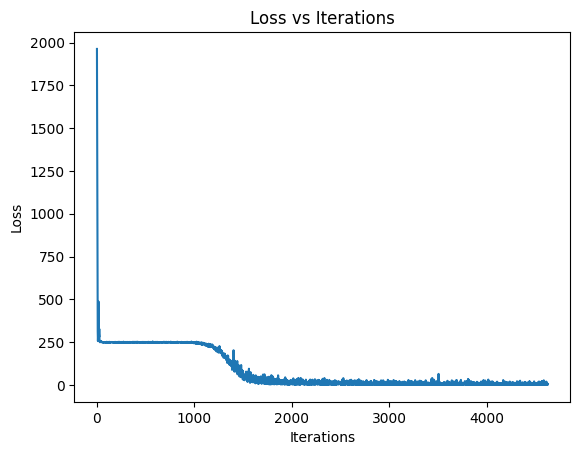

In [80]:
plt.plot(loss_values)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.show()

In [81]:
acc = evaluate_model()
print(acc)

125it [00:11, 10.93it/s]

(0.925, 0.3976187497526407)
